# Flagging the hopping tracks

In [1]:
import pandas as pd
import numpy as np
import os
from os.path import dirname, join
from tkinter import filedialog
from copy import deepcopy
import tifffile
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

In [2]:
# parameters
consecutive_window = 3
threshold_alpha = 1
threshold_D = 0.15 # um2/s
threshold_R2 = 0.5

In [3]:
def flag_tracks(df):
    track_flags = {}
    step_flags = []
    trackIDs = df["trackID"].unique()

    for track_id in trackIDs:
        track_data = df[df["trackID"] == track_id]
        high_alpha = track_data["alpha"] > threshold_alpha
        step_flags_pertrack = np.repeat(False, track_data.shape[0])

        for i in range(len(high_alpha) - (consecutive_window - 1)):
            if all(high_alpha[i : i + consecutive_window]):
                if (
                    np.mean(track_data["D"][i : i + consecutive_window]) > threshold_D
                    and np.mean(track_data["R2"][i : i + consecutive_window])
                    > threshold_R2
                ):
                    track_flags[track_id] = True
                    step_flags_pertrack[i : i + consecutive_window] = True
        step_flags.extend(step_flags_pertrack)

    df_out = deepcopy(df)
    df_out["step_flag"] = step_flags

    return df_out, track_flags

In [4]:
csv_file_path = r"Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\no_drug\Analysed Data\2x\Alpha and D calculated\20240118_UGD-2x-2s-replicate1-FOV-2_reformatted_processed_alpha_and_D_w5.csv"

In [5]:
df = pd.read_csv(csv_file_path)
df_out, track_flags = flag_tracks(df)

In [6]:
print(len(track_flags))

120


In [7]:
df_out.to_csv(csv_file_path[:-4] + "-wstepflags.csv", index=False)
print(len(track_flags))
for track_id, flagged in track_flags.items():
    if flagged:
        print(track_id)

120
2
5
6
16
19
21
33
34
37
57
59
80
83
93
94
96
121
123
135
137
150
155
158
160
162
166
176
193
194
200
204
219
226
231
234
239
240
252
267
271
284
291
298
300
341
357
364
365
385
386
388
391
403
405
413
414
416
418
425
427
428
432
436
437
441
443
447
448
450
454
462
463
469
484
487
489
491
497
500
504
508
513
518
520
521
526
531
537
540
549
551
552
557
560
562
567
590
605
640
642
658
738
762
790
791
792
820
895
942
954
983
990
991
1008
1031
1070
1106
1128
1304
1347


In [8]:
tif_file_path = r"Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\no_drug\2x\20240118_UGD-2x-2s-replicate1-FOV-2.tif"
with tifffile.TiffFile(tif_file_path) as tif:
    video = tif.asarray()

In [9]:
output_video_path = "Z:/Bisal_Halder_turbo/PROCESSED_DATA/Trial_analysis/animated_video_with_tracks.mp4"

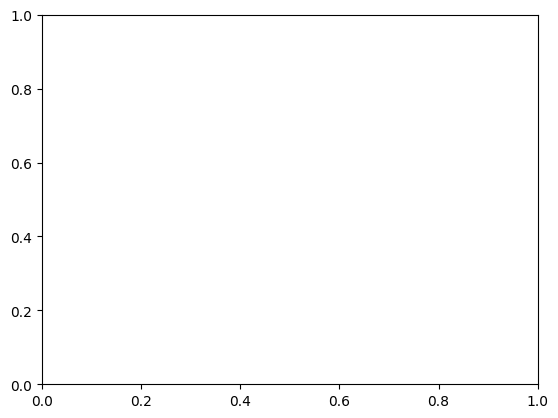

In [10]:
fig, ax = plt.subplots()

In [11]:
def animate(frame):
    ax.clear()
    img = video[frame]
    ax.imshow(img, cmap = 'grey')

    current_tracks = df_out[df_out["t"] == frame]
    for track_id in current_tracks["trackID"].unique():
        track = current_tracks[current_tracks["trackID"] == track_id]
        x_plot = track["x"].to_numpy()
        y_plot = track["y"].to_numpy()

        track_color = 'red' if track_flags.get(track_id, False) else 'green'
        ax.plot(x_plot, y_plot, '-o', color=track_color, lw=2, markersize=3)

    ax.axis('off')

In [12]:
ani = FuncAnimation(fig, animate, frames=len(video), interval=50, repeat=False)

In [13]:
writer = animation.FFMpegWriter(fps = 20)

In [14]:
ani.save(output_video_path, writer=writer)

In [15]:
plt.close(fig)